In [2]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt

class ZBL():

    def __init__(self, Zi, Zj):
        
        self.Zi = Zi
        self.Zj = Zj

        e0 = 55.26349406e-4

        K = 1/(4*np.pi*e0)

        self.a = 0.46850/(self.Zi**0.23 + self.Zj**0.23)	

        self.amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
        self.exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])

        self.constant = K*Zi*Zj

    def eval_zbl(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
            
        return (self.constant/rij)*phi

    def eval_grad(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])

        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(dphi/self.a - phi/rij)
    
    def eval_hess(self, rij):

        if isinstance(rij, (int, float)):
            rij = np.array([rij])
            
        x = rij/self.a

        x = x[:, np.newaxis]

        phi = np.sum(self.amplitude * np.exp(-self.exponent * x), axis=1)
        
        dphi = np.sum(-self.amplitude*self.exponent * np.exp(-self.exponent * x), axis=1)

        d2phi = np.sum(self.amplitude*self.exponent**2 * np.exp(-self.exponent * x), axis=1)

        return (self.constant/rij)*(d2phi/self.a**2 - 2*dphi/(self.a*rij) + 2*phi/rij**2)

In [3]:
class Fitting_Potential():

    def __init__(self, hyperparams, potlines):

        # Decompose Sample as follows: [ F, Rho, W-He, H-He, He-He ]

        # For F the knots are: [0, rho_1 ... rho_f, rho_c], [0, F(rho_1) ... F(rho_f), F(rho_c)] f + 2 is the number knot points requires: 2f + 1 params 

        # For Rho the knots are: [0, r_1 ... r_rho, r_c], [0, Rho(r_1) ... Rho(r_rho), Rho(r_c)] rho + 2 is the number knot points requires: 2rho + 1 params

        # For V (pair pot) are: [0, r_1 ... r_v, r_c], [0, V(r_1) ... V(r_v), -Z(r_c)] v + 2 is the number knot points requires: 2v params

        self.keys  = ['He_F(rho)','He_rho(r)', 'W-He', 'H-He', 'He-He']

        self.hyper = hyperparams

        self.potlines = potlines

        self.nf = 0
        self.nrho = 0
        self.nv = 3

        self.knot_pts = {}

        self.knot_pts['He_F(rho)'] = np.linspace(0, self.hyper['rho_c'], self.nf + 2)
        self.knot_pts['He_rho(r)'] = np.linspace(0, self.hyper['rc'], self.nrho + 2)
        self.knot_pts['W-He'] = np.array([0, 2.0376, 2.8161, 3.6429, self.hyper['rc']])
        self.knot_pts['H-He'] = np.array([0, 1.4841, 2.3047, 3.6429, self.hyper['rc']])
        self.knot_pts['He-He'] = np.array([0, 1.4841, 2.3047, 3.6429, self.hyper['rc']])

        self.map = {}

        map_idx = [self.nf + 1] + [self.nrho + 1] + 3*[self.nv]

        idx = 0
        iter = 0

        idx = 0
        iter = 0

        for key in self.keys:
            self.map[key] = slice(idx, idx + map_idx[iter])
            idx += map_idx[iter]
            iter += 1
        
        self.len_sample = idx

    def sample_to_array(self, sample_dict):
        
        sample_lst = []

        for key in self.keys:

            for val in sample_dict[key]:

                sample_lst.append(val)

        return np.array(sample_lst)
    
    def array_to_sample(self, sample_arr):
        
        sample_dict = {}

        for key in self.keys:
            sample_dict[key] = sample_arr[self.map[key]]

        return sample_dict


    def init_sample(self, isrand = False):

        sample = np.zeros((self.len_sample,))

        if isrand:
            
            sample = self.gen_rand()

        else:
            
            with open("../Init.json", "r") as json_file:
                loaded_data = json.load(json_file)

            ref = {}
            for key, value in loaded_data.items():
                ref[key] = np.array(value)

            # Initialize based on prior beliefs
            # Knot points are equispaced in the given range

            # Assume linear relationship between F and rho
            sample[self.map['He_F(rho)']] = 0.37*np.linspace(0, self.hyper['rho_c'], self.nf + 2)[1:]

                        
            # Assume that the electron density is zero
            sample[self.map['He_rho(r)']] = np.zeros((self.nrho + 1,))

            charge = np.array([[74, 2],
                              [1, 2],
                              [2, 2]])
            
            
            for i, key in enumerate(['W-He', 'H-He', 'He-He']):
                
                zbl = ZBL(charge[i,0], charge[i,1])
                                
                idx = np.floor(self.knot_pts[key][1:-1]/self.hyper['dr']).astype(int)

                sample[self.map[key]] = ref[key][idx]/self.knot_pts[key][1:-1] - zbl.eval_zbl(self.knot_pts[key][1:-1])

        return sample
    
    def gen_rand(self):
            
        sample = np.zeros((self.len_sample,))
        
        # Randomly Generate Knot Values for F(rho)
        sample[self.map['He_F(rho)']] = self.hyper['rho_c']*np.random.rand(self.nf + 1)

        # Randomly Generate Knot Values for Rho(r)
        sample[self.map['He_rho(r)']] = np.random.randn(self.nrho + 1)

        for i, key in enumerate(['W-He', 'H-He', 'He-He']):

            # Randomly Generate Knot Values for Rho(r)
            scale = 2
            shift = 0.5

            sample[self.map[key]] = scale*(np.random.rand(self.nv) - shift)
    
        return sample
    
    def polyfit(self, x_arr, y_arr, dy_arr, d2y_arr):
        
        n_none = 0

        for lst in [y_arr, dy_arr, d2y_arr]:
            
            lst = lst.tolist()
            n_none += lst.count(None)
        
        dof = 3*len(x_arr) - n_none

        Phi = []
        Y   = []

        for i, x in enumerate(x_arr):

            y = y_arr[i]
            dy = dy_arr[i]
            d2y = d2y_arr[i]

            if y is not None:
                Phi.append(np.array([x**i for i in range(dof)]).T)
                Y.append(y)

            if dy is not None:
                Phi.append(np.array([i*x**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T)
                Y.append(dy)

            if d2y is not None:
                Phi.append(np.array([i*(i-1)*x**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T)
                Y.append(d2y)
            
        Phi = np.array(Phi)

        Y  = np.array(Y)

        return np.linalg.solve(Phi, Y)

    def polyval(self, x, coef, func = True, grad = False, hess = False):

        dof = len(coef)

        if func:
            Phi = np.array([x**i for i in range(dof)]).T
        
        elif grad:
            Phi = np.array([i*x**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T

        elif hess:
            Phi = np.array([i*(i-1)*x**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T

        if x.ndim == 1:
            return np.dot(Phi, coef)

        else:
            return np.dot(Phi, coef.reshape(-1,1)).flatten()
    
    def fit_sample(self, sample):

        coef_dict = {}

        y = np.zeros((self.nf + 2,))

        y[1:] = sample[self.map['He_F(rho)']]

        dy = np.full(y.shape, None, dtype=object)

        d2y = np.full(y.shape, None, dtype=object)

        coef_dict['He_F(rho)'] = self.polyfit(self.knot_pts['He_F(rho)'], y, dy, d2y)


        y = np.zeros((self.nrho + 2,))

        y[:-1] = sample[self.map['He_rho(r)']]

        dy = np.full(y.shape, None)

        d2y = np.full(y.shape, None)

        dy[-1] = 0

        d2y[-1] = 0

        coef_dict['He_rho(r)'] = self.polyfit(self.knot_pts['He_rho(r)'], y, dy, d2y)

        charge = [[74, 2],[1, 2],[2, 2]]

        for i, key in enumerate(['W-He', 'H-He', 'He-He']):

            zbl_class = ZBL(charge[i][0], charge[i][1])
            
            x = self.knot_pts[key]

            y = np.zeros((self.nv + 2,))

            y[1:-1] = sample[self.map[key]]

            dy = np.full(y.shape, None)

            d2y = np.full(y.shape, None)

            dy[0] = 0

            d2y[0] = 0

            y[-1] = -zbl_class.eval_zbl(x[-1])[0]

            dy[-1] = -zbl_class.eval_grad(x[-1])[0]

            d2y[-1] = -zbl_class.eval_hess(x[-1])[0]

            coef_dict[key] = self.polyfit(x, y, dy, d2y)

        return coef_dict
    
    def sample_to_file(self, sample, pot):

        coef_dict = self.fit_sample(sample)
        
        rho = np.linspace(0, self.hyper['rho_c'], self.hyper['Nrho'])

        r = np.linspace(0, self.hyper['rc'], self.hyper['Nr'])

        pot['He_F(rho)'] = self.polyval(rho, coef_dict['He_F(rho)'], func = True, grad = False, hess = False)
        pot['He_rho(r)'] = self.polyval(r, coef_dict['He_rho(r)'], func = True, grad = False, hess = False)

        charge = [[74, 2],[1, 2],[2, 2]]
        for i, key in enumerate(['W-He', 'H-He', 'He-He']):

            zbl_class = ZBL(charge[i][0], charge[i][1])
            zbl = zbl_class.eval_zbl(r[1:])

            poly = self.polyval(r[1:], coef_dict[key], func = True, grad = False, hess = False)

            pot[key][1:] = r[1:]*(zbl + poly)

        return pot

In [4]:
pot_params = {}

pot_params['Nrho'] = 10000
pot_params['drho'] = 0.0019792116    
pot_params['Nr']   = 5000
pot_params['dr']   = 0.0009702778    
pot_params['rc']  = 4.8513889200
pot_params['rho_c']  = pot_params['Nrho'] * pot_params['drho']

rho = np.linspace(0, pot_params['rho_c'], pot_params['Nrho'])
r = np.linspace(0, pot_params['rc'], pot_params['Nr'])

with open("../Init.json", "r") as json_file:
    loaded_data = json.load(json_file)

ref = {}

for key, value in loaded_data.items():
    ref[key] = np.array(value)


In [5]:
inst = Fitting_Potential(pot_params, '')

sample = inst.init_sample(isrand = True)

print(sample.shape)
coef = inst.fit_sample(sample)

pot = inst.sample_to_file(sample, ref)

(11,)


Text(0, 0.5, 'Energy /eV')

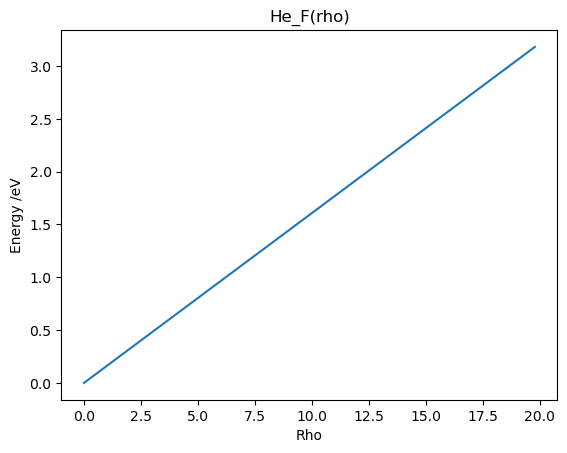

In [6]:
k = 0
key = 'He_F(rho)'
plt.plot(rho[k:], pot[key][k:])
plt.title(key)
plt.xlabel('Rho')
plt.ylabel('Energy /eV')

Text(0, 0.5, 'Electron Density')

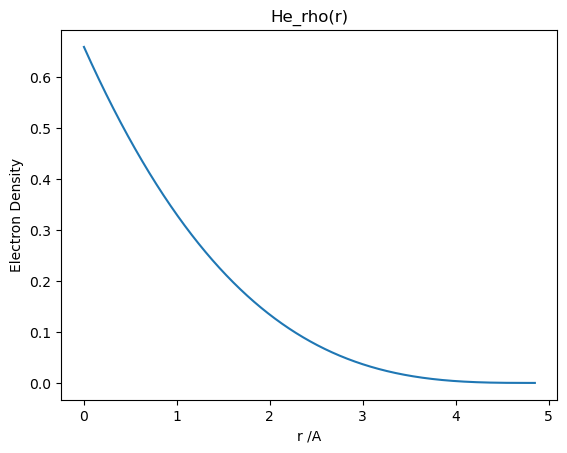

In [7]:
k = 0
key = 'He_rho(r)'
plt.plot(r[k:], pot[key][k:])
plt.title(key)
plt.xlabel('r /A')
plt.ylabel('Electron Density')

Text(0, 0.5, 'Energy /eV')

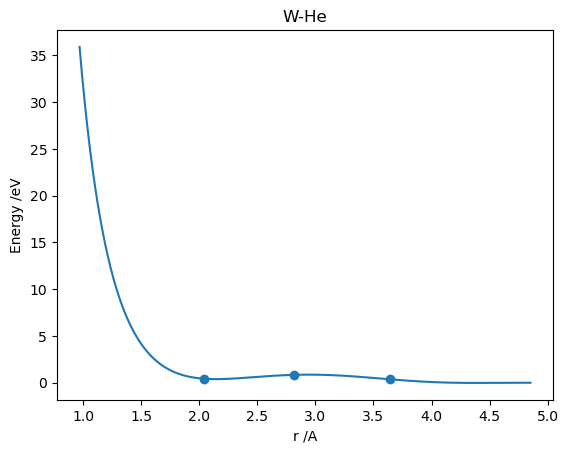

In [8]:
k = 1000
zbl = ZBL(2,74)

key = 'W-He'
plt.plot(r[k:], pot[key][k:]/r[k:])
plt.scatter(inst.knot_pts[key][1:-1], sample[inst.map[key]] + zbl.eval_zbl(inst.knot_pts[key][1:-1]))

plt.title(key)
plt.xlabel('r /A')
plt.ylabel('Energy /eV')

Text(0, 0.5, 'Energy /eV')

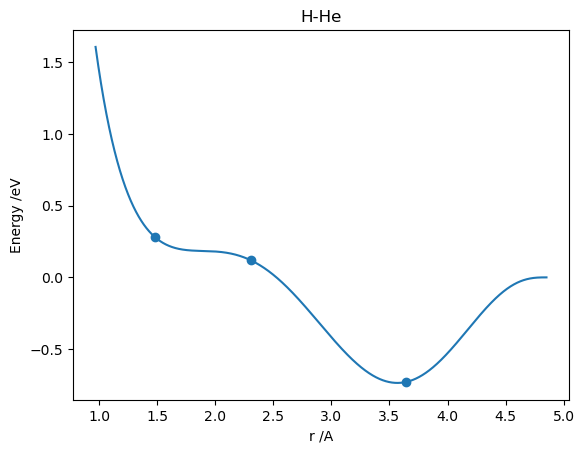

In [9]:
k = 1000
zbl = ZBL(2,1)

key = 'H-He'
plt.plot(r[k:], pot[key][k:]/r[k:])
plt.scatter(inst.knot_pts[key][1:-1], sample[inst.map[key]] + zbl.eval_zbl(inst.knot_pts[key][1:-1]))

plt.title(key)
plt.xlabel('r /A')
plt.ylabel('Energy /eV')

Text(0, 0.5, 'Energy /eV')

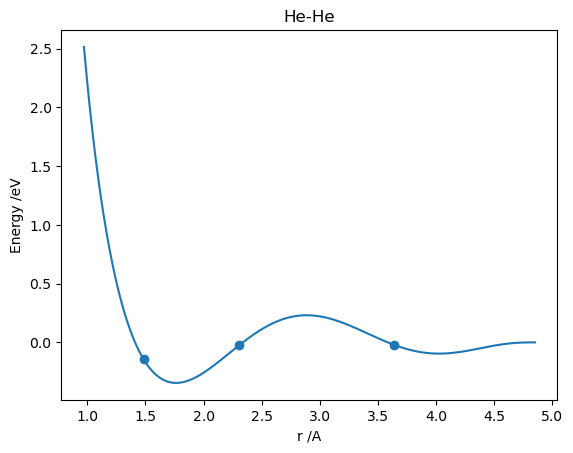

In [10]:
k = 1000
zbl = ZBL(2,2)

key = 'He-He'
plt.plot(r[k:], pot[key][k:]/r[k:])
plt.scatter(inst.knot_pts[key][1:-1], sample[inst.map[key]] + zbl.eval_zbl(inst.knot_pts[key][1:-1]))

plt.title(key)
plt.xlabel('r /A')
plt.ylabel('Energy /eV')

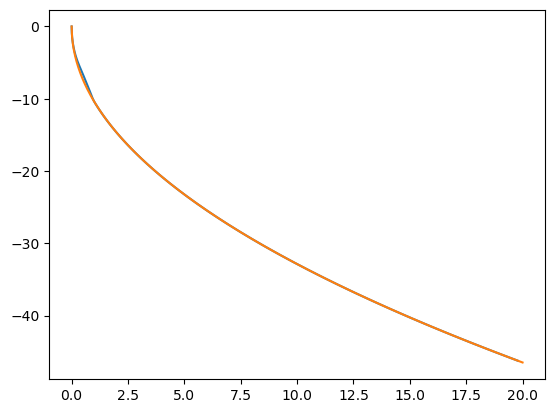

In [11]:
plt.plot(np.arange(pot_params['Nrho'])*pot_params['drho'],pot['W_F(rho)'])

idx = np.floor(np.linspace(0,19, 4)/pot_params['drho']).astype(int)

y_knot = pot['W_F(rho)'][idx] + 10.39248715*np.sqrt(idx*pot_params['drho'])
x_knot = idx*pot_params['drho']
dy_knot = np.full(shape=y_knot.shape, fill_value=None)
d2y_knot = np.full(shape=y_knot.shape, fill_value=None)

coef = inst.polyfit(x_knot, y_knot, dy_knot, d2y_knot)

x = np.linspace(0, 20, 1000)
y = inst.polyval(x, coef) - 10.39248715*np.sqrt(x)
plt.plot(x, y)

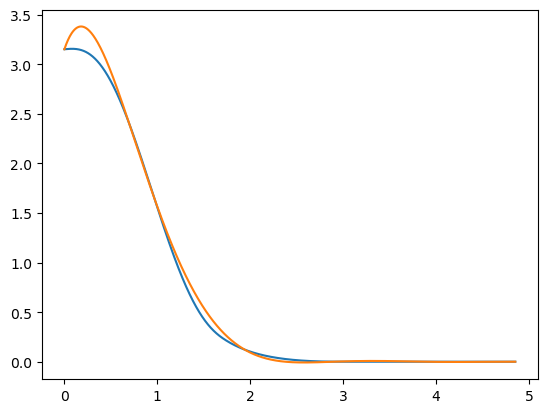

In [12]:
plt.plot(np.arange(pot_params['Nr'])*pot_params['dr'],pot['H_rho(r)'])

idx = np.floor(np.linspace(0,len(pot['H_rho(r)'])-1, 6)).astype(int)

y_knot = pot['H_rho(r)'][idx]
x_knot = idx*pot_params['dr']
dy_knot = np.full(shape=y_knot.shape, fill_value=None)
d2y_knot = np.full(shape=y_knot.shape, fill_value=None)
dy_knot[-1] = 0 
d2y_knot[-1] = 0
coef = inst.polyfit(x_knot, y_knot, dy_knot, d2y_knot)

x = np.linspace(0, 4.85, 1000)
y = inst.polyval(x, coef)

plt.plot(x, y)

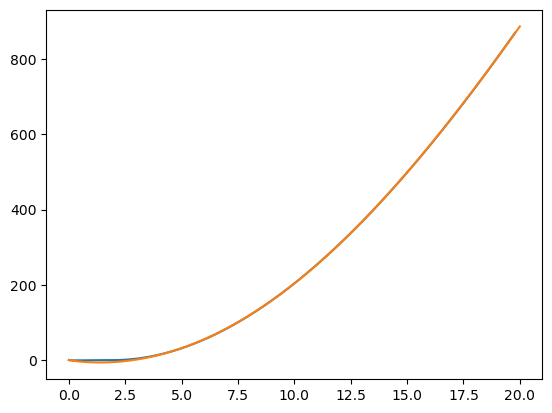

In [13]:
plt.plot(np.arange(pot_params['Nrho'])*pot_params['drho'],pot['H_F(rho)'])

idx = np.floor(np.linspace(0,19, 5)/pot_params['drho']).astype(int)

y_knot = pot['H_F(rho)'][idx] + 2.094997341*np.sqrt(idx*pot_params['drho'])
x_knot = idx*pot_params['drho']
dy_knot = np.full(shape=y_knot.shape, fill_value=None)
d2y_knot = np.full(shape=y_knot.shape, fill_value=None)

coef = inst.polyfit(x_knot, y_knot, dy_knot, d2y_knot)

x = np.linspace(0, 20, 1000)
y = inst.polyval(x, coef) - 2.094997341*np.sqrt(x)
plt.plot(x, y)

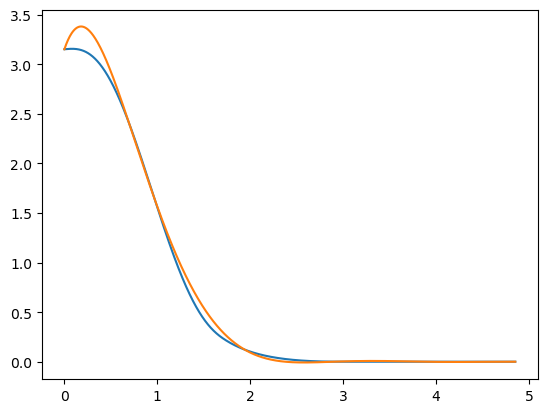

In [14]:
plt.plot(np.arange(pot_params['Nr'])*pot_params['dr'],pot['H_rho(r)'])

idx = np.floor(np.linspace(0,len(pot['H_rho(r)'])-1, 6)).astype(int)

y_knot = pot['H_rho(r)'][idx]
x_knot = idx*pot_params['dr']
dy_knot = np.full(shape=y_knot.shape, fill_value=None)
d2y_knot = np.full(shape=y_knot.shape, fill_value=None)
dy_knot[-1] = 0 
d2y_knot[-1] = 0
coef = inst.polyfit(x_knot, y_knot, dy_knot, d2y_knot)

x = np.linspace(0, 4.85, 1000)
y = inst.polyval(x, coef)

plt.plot(x, y)

In [15]:
with open('../Optimization_Files/Final_Optima.json', 'r') as file:
    data = json.load(file)

data['Loss'] = np.array(data['Loss'])

min_val = data['Loss'].min()
min_idx = data['Loss'].argmin()

'''[ 6.16 11.32 16.13 20.6  24.92  5.03  8.02 11.04 14.01 17.96] '''
'''[ 0.36  0.8   1.16  1.65  2.03 -0.24 -0.06  0.14  0.38  0.71] '''

print(min_val, min_idx)

opt_sample = np.array(data['Optima'][min_idx])

opt = inst.sample_to_file(opt_sample,pot)

print(opt_sample, opt_sample.shape)

0.03209956763859052 96
[15.08900891 -0.2248929  -0.27003165 -0.20166809 -0.2729355   1.04670084
 -0.32244924 -0.30738637  0.23413798  0.97718224 -1.06525588] (11,)


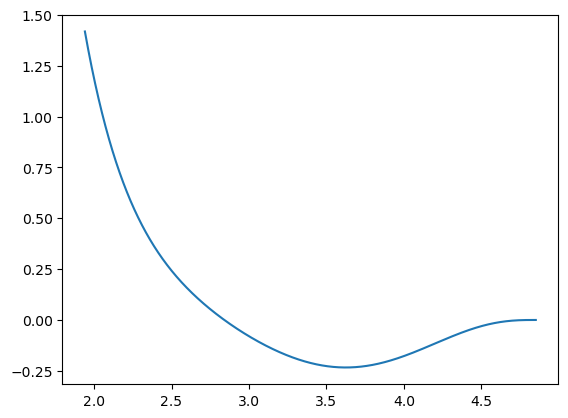

In [16]:
k = 2000

plt.plot(r[k:], opt['W-He'][k:]/r[k:])

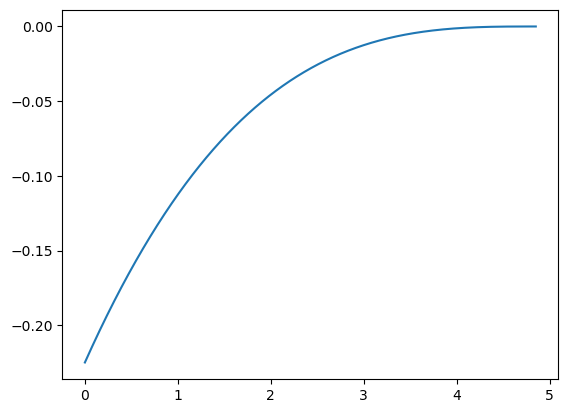

In [17]:
plt.plot(r, opt['He_rho(r)'])

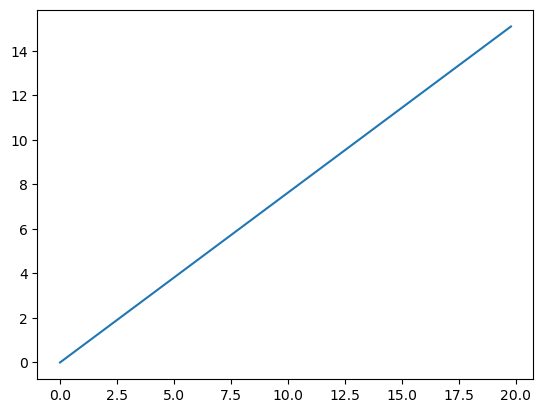

In [18]:
plt.plot(rho, opt['He_F(rho)'])

In [19]:
for key in opt:
    opt[key] = pot[key].tolist()


with open('Test_negative_rho.json', 'w') as file:

    json.dump(opt, file)